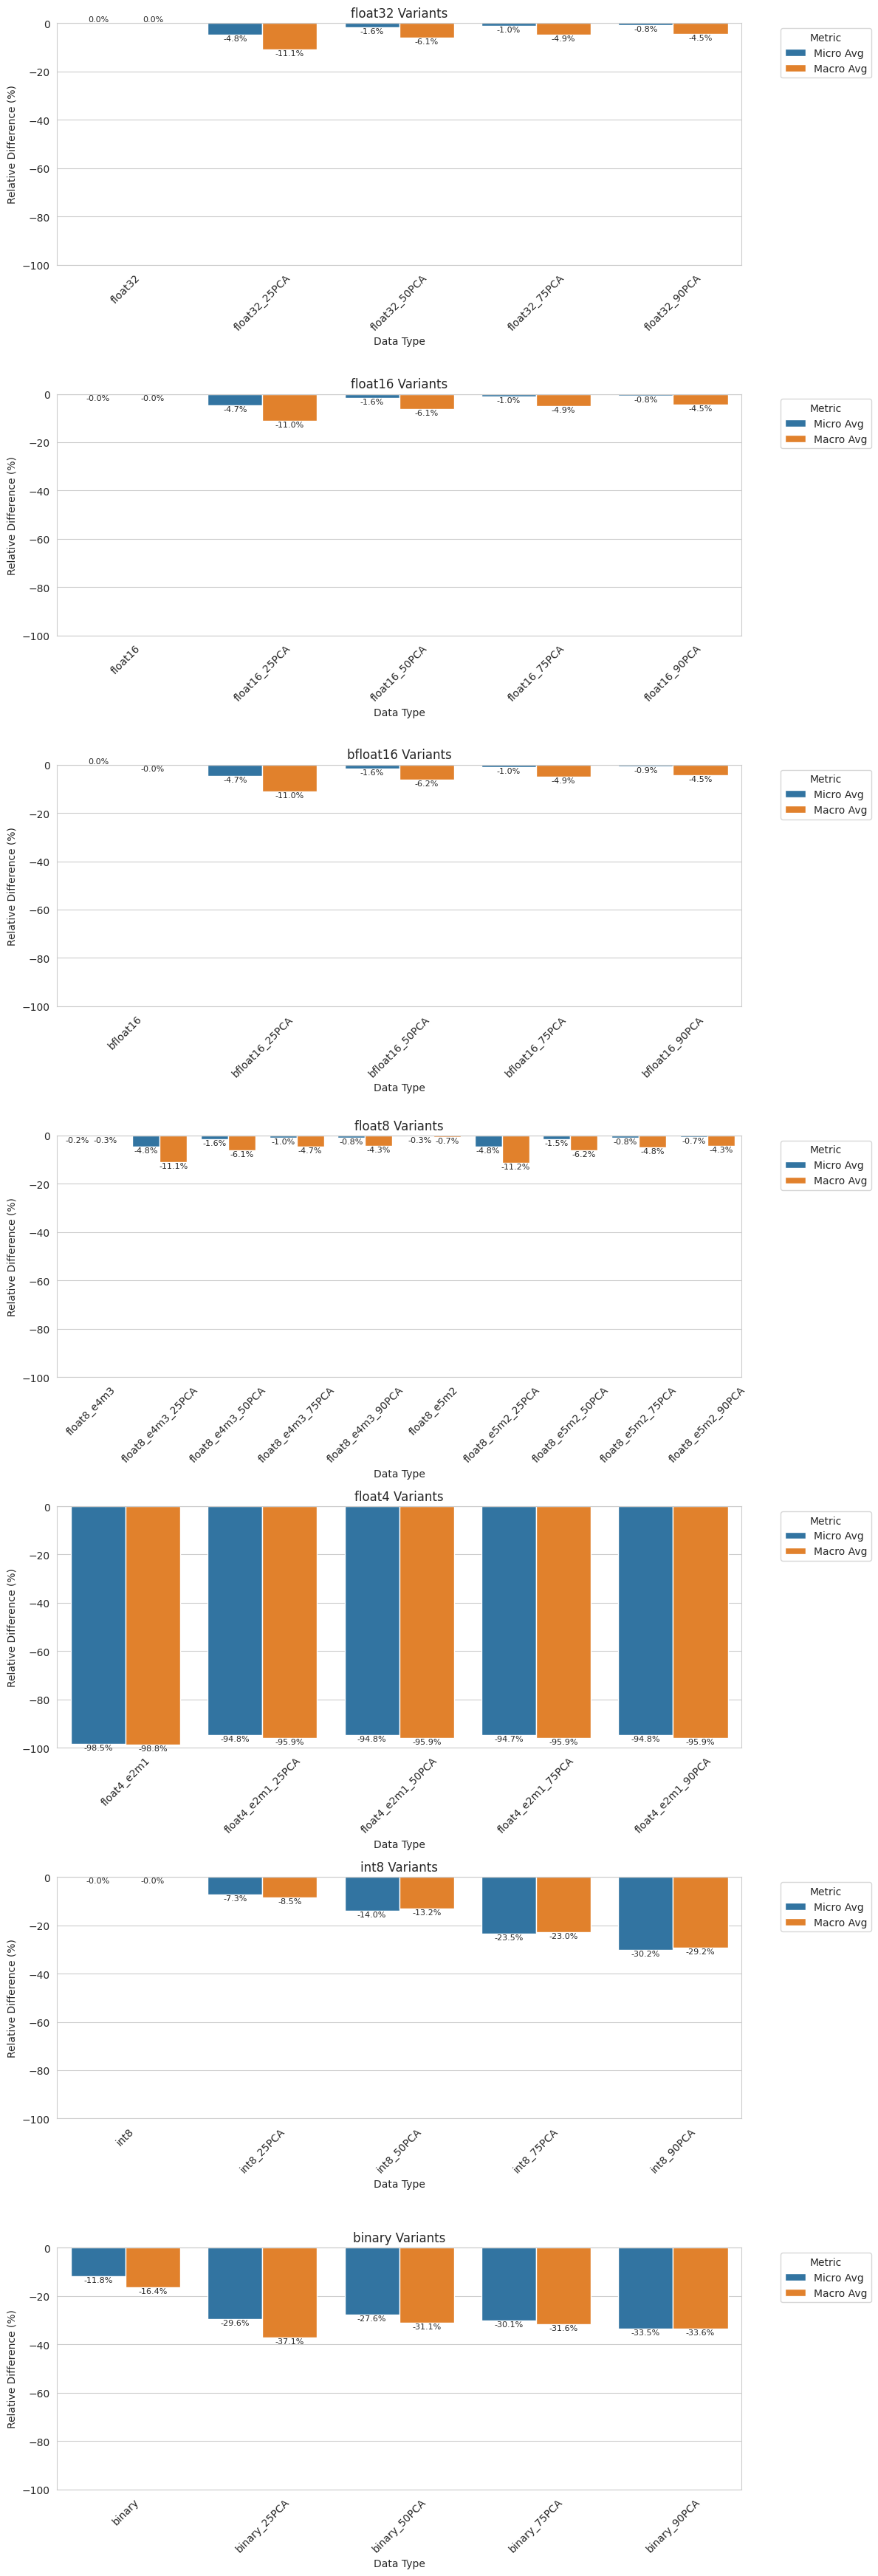

In [3]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Get all result files from the experiment directory
results_dir = Path('../results/BAAI/bge-small-en-v1.5')
result_files = list(results_dir.glob('results_*.json'))

# Load float32 baseline scores
with open(results_dir / 'results_float32.json', 'r') as f:
    float32_data = json.load(f)
    float32_scores = float32_data['scores']

# Group files by base data type
dtype_groups = {
    'float32': [],
    'float16': [],
    'bfloat16': [],
    'float8': [],
    'float4': [],
    'int8': [],
    'binary': []
}

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Check exact match for float16 and bfloat16 to avoid mixing them up
    if dtype == 'float16' or dtype.startswith('float16_'):
        dtype_groups['float16'].append(result_file)
    elif dtype == 'bfloat16' or dtype.startswith('bfloat16_'):
        dtype_groups['bfloat16'].append(result_file)
    else:
        # For other types, check if base type is in the name
        for base_type in ['float32', 'float8', 'float4', 'int8', 'binary']:
            if base_type in dtype:
                dtype_groups[base_type].append(result_file)

# Create subplot for each data type
fig, axes = plt.subplots(len(dtype_groups), 1, figsize=(12, 5*len(dtype_groups)))
# fig.suptitle('Relative Performance Difference vs float32 (no PCA)', fontsize=16)

for idx, (base_type, files) in enumerate(dtype_groups.items()):
    if not files:
        continue
        
    dtypes = []
    metrics = []
    relative_scores = []
    
    for result_file in files:
        dtype = result_file.stem.replace('results_', '')
        with open(result_file, 'r') as f:
            data = json.load(f)
            
        # Calculate micro average
        micro_avg = sum(data['scores'].values()) / len(data['scores'])
        micro_baseline = sum(float32_scores.values()) / len(float32_scores)
        micro_diff = ((micro_avg - micro_baseline) / micro_baseline) * 100
        
        # Calculate macro average
        macro_avg = sum(((score - float32_scores[benchmark]) / float32_scores[benchmark]) * 100 
                       for benchmark, score in data['scores'].items()) / len(data['scores'])
        
        dtypes.extend([dtype] * 2)
        metrics.extend(['Micro Avg', 'Macro Avg'])
        relative_scores.extend([micro_diff, macro_avg])

    df = pd.DataFrame({
        'dtype': dtypes,
        'metric': metrics,
        'relative_diff': relative_scores
    })

    # Create subplot
    sns.set_style("whitegrid")
    ax = axes[idx]
    sns.barplot(data=df, x='dtype', y='relative_diff', hue='metric', order=sorted(df['dtype'].unique()), ax=ax)
    
    ax.set_title(f'{base_type} Variants')
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Relative Difference (%)')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Set y-axis limits from -100 to 0
    ax.set_ylim(-100, 0)
    
    # Add legend
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.show()


KeyError: 'uploaded_points_per_second'

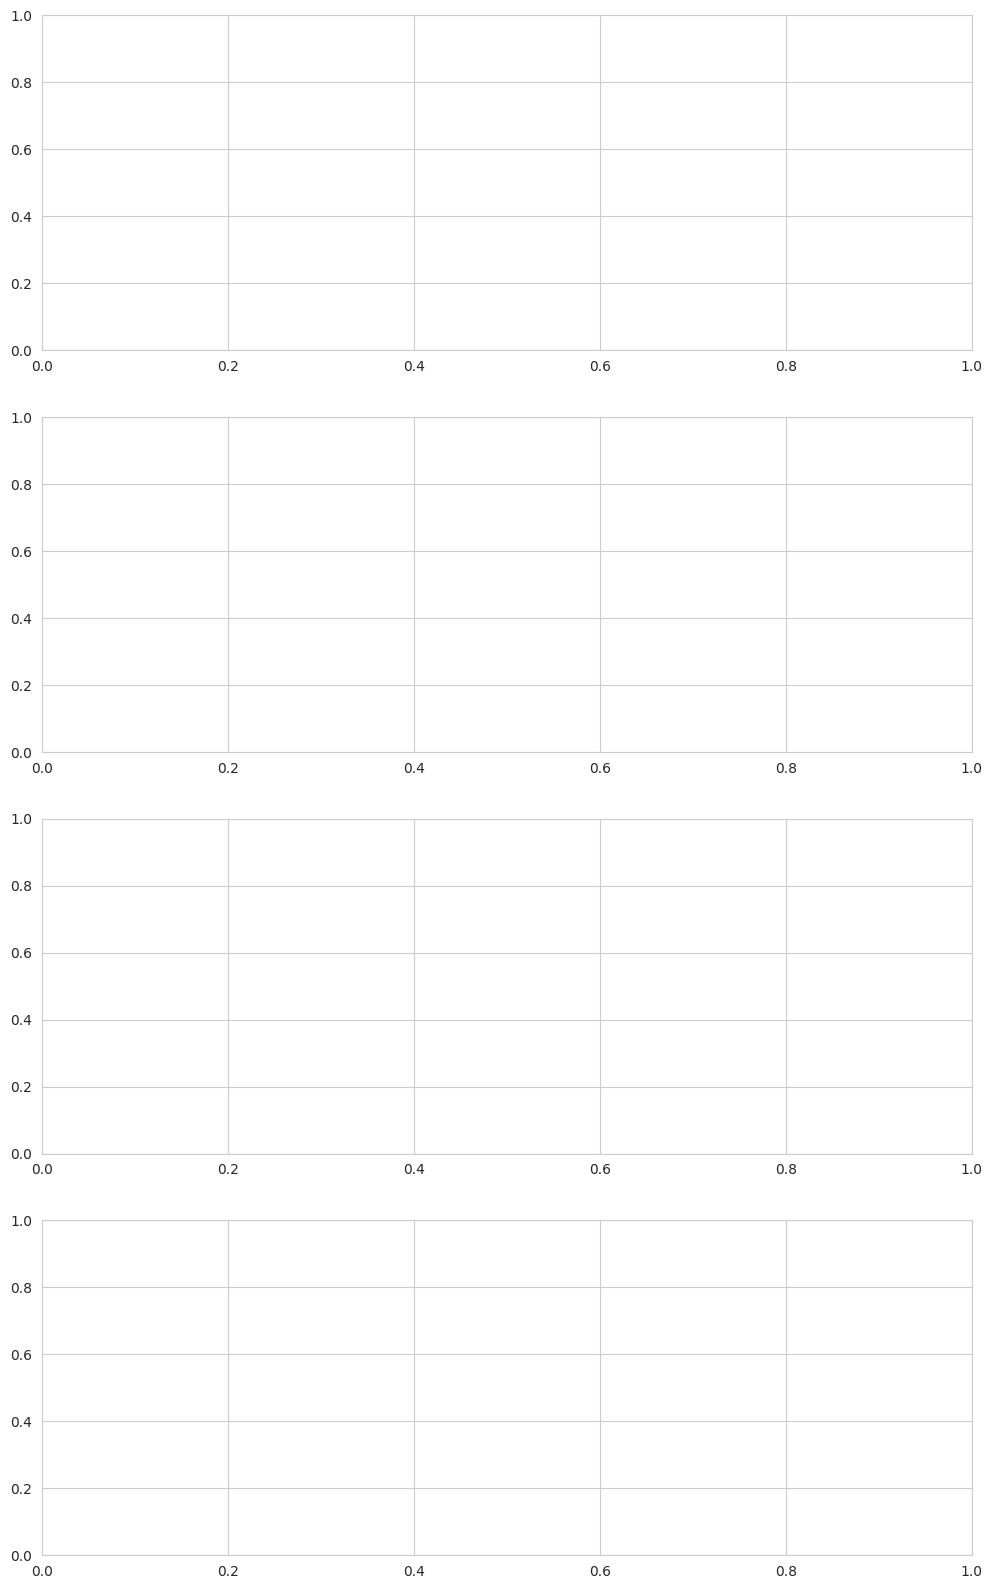

In [4]:
# Get all result files from the Qdrant experiment directory
results_dir = Path('../results/qdrant/BAAI/bge-small-en-v1.5')
result_files = list(results_dir.glob('results_*.json'))

# Group files by base data type
dtype_groups = {
    'float32': [],
    'float16': [], 
    'int8': [],
    'binary': []
}

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            dtype_groups[base_type].append(result_file)

# Create subplot for each data type
fig, axes = plt.subplots(len(dtype_groups), 1, figsize=(12, 5*len(dtype_groups)))

for idx, (base_type, files) in enumerate(dtype_groups.items()):
    if not files:
        continue
        
    dtypes = []
    metrics = []
    values = []
    
    for result_file in files:
        dtype = result_file.stem.replace('results_', '')
        with open(result_file, 'r') as f:
            data = json.load(f)
            
        # Extract key metrics
        dtypes.extend([dtype] * 2)
        metrics.extend(['Upload Speed (pts/s)', 'Query Speed (qps)'])
        values.extend([
            data['uploaded_points_per_second'],
            data['queries_per_second']
        ])

    df = pd.DataFrame({
        'dtype': dtypes,
        'metric': metrics,
        'value': values
    })

    # Create subplot
    sns.set_style("whitegrid")
    ax = axes[idx]
    sns.barplot(data=df, x='dtype', y='value', hue='metric', 
                order=sorted(df['dtype'].unique()), ax=ax)
    
    ax.set_title(f'{base_type} Variants')
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)
    
    # Add legend
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.show()


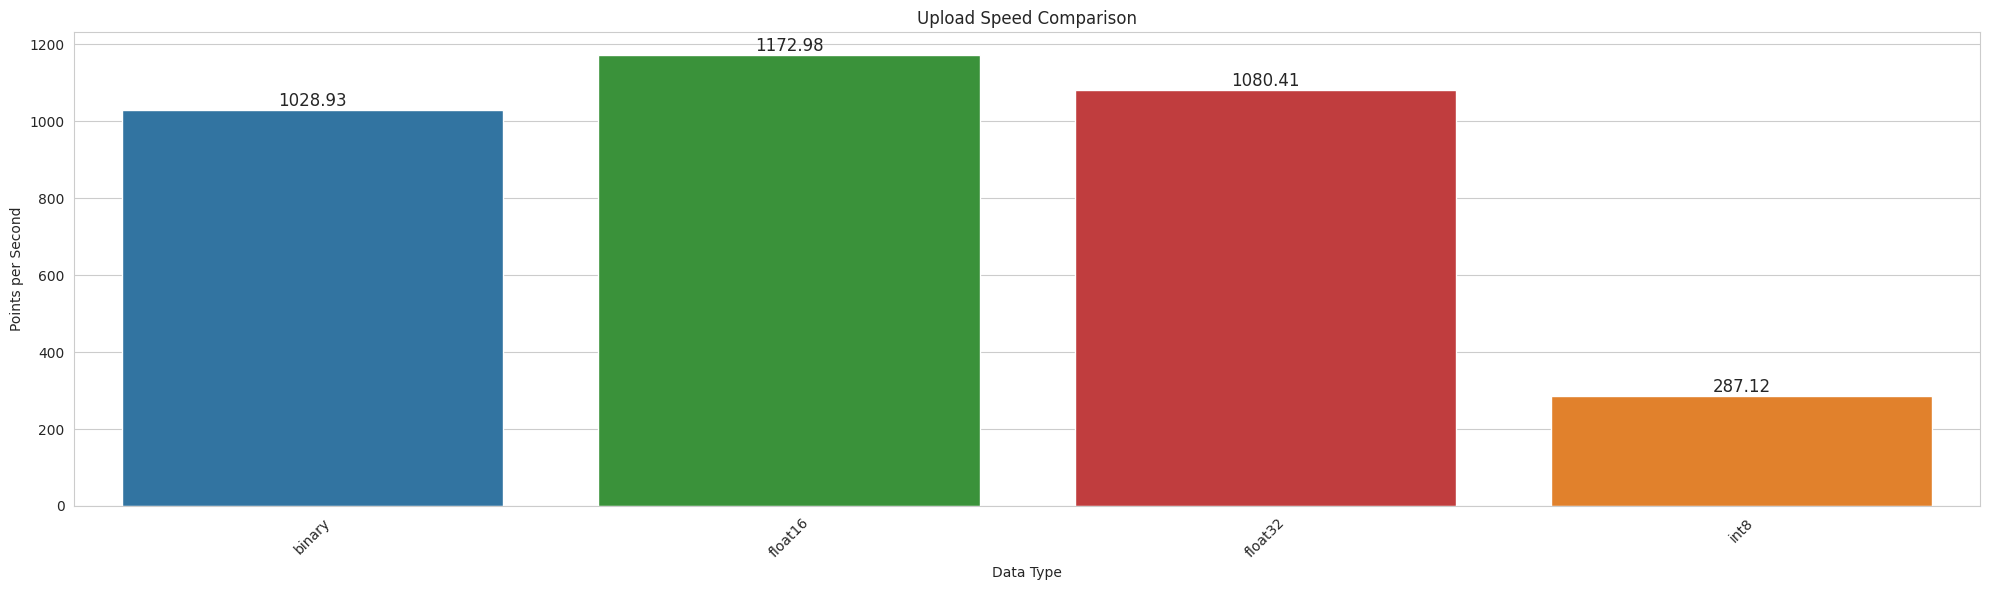

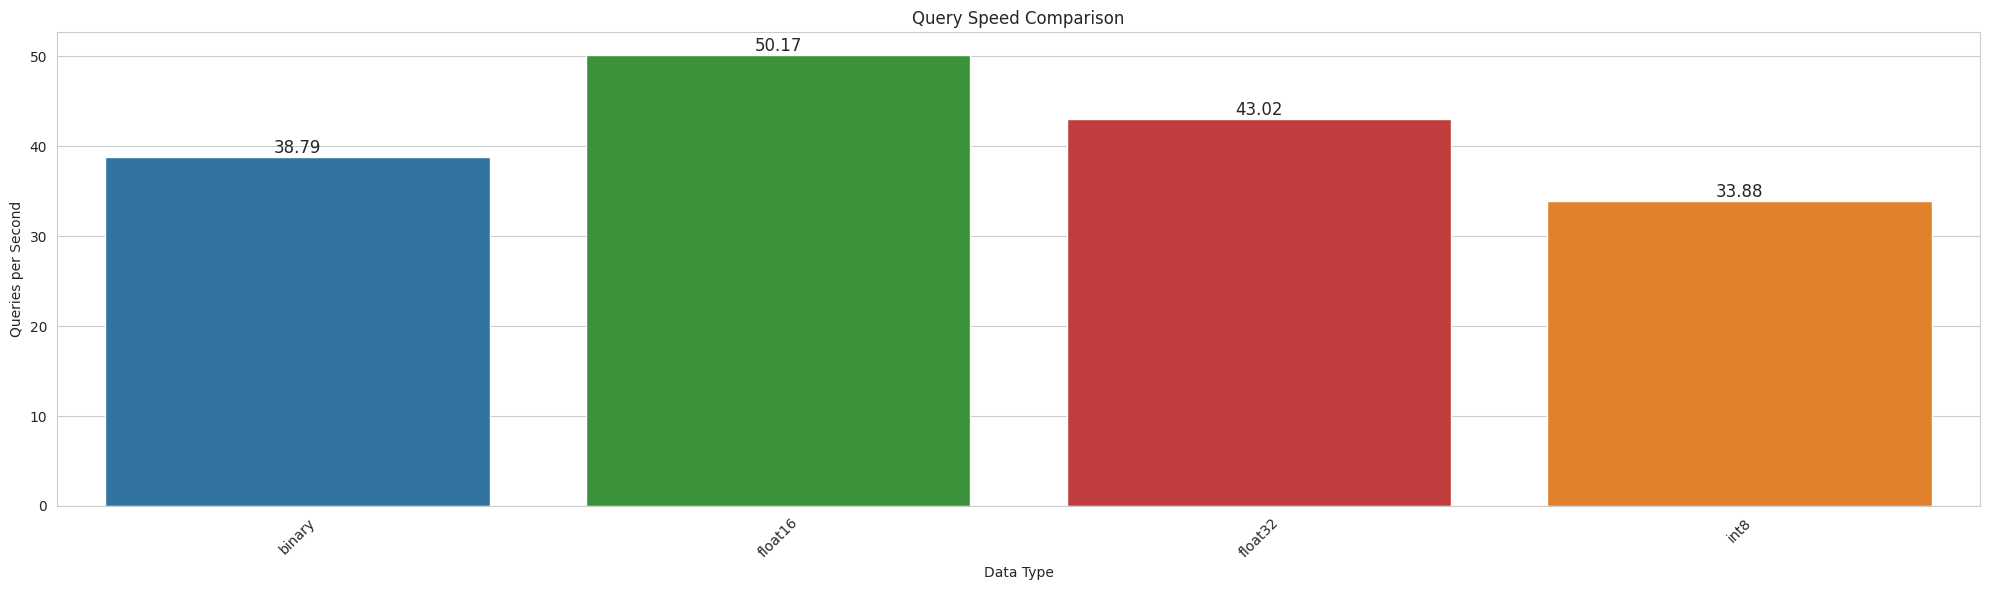

In [12]:
# Get all result files from the Qdrant experiment directory
results_dir = Path('../results/qdrant/BAAI/bge-small-en-v1.5')
result_files = list(results_dir.glob('results_*.json'))

# Group files by base data type
dtype_groups = {
    'float32': [],
    'float16': [], 
    'int8': [],
    'binary': []
}

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type  
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            dtype_groups[base_type].append(result_file)

# Prepare data
dtypes = []
upload_speeds = []
query_speeds = []
base_types = []

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            dtypes.append(dtype)
            upload_speeds.append(data['uploaded_points_per_second'])
            query_speeds.append(data['queries_per_second'])
            base_types.append(base_type)

# Upload speed plot
plt.figure(figsize=(20, 6))
df_upload = pd.DataFrame({
    'dtype': dtypes,
    'value': upload_speeds,
    'base_type': base_types
})

sns.barplot(data=df_upload, x='dtype', y='value', hue='base_type',
            order=sorted(df_upload['dtype'].unique()))
plt.title('Upload Speed Comparison')
plt.xlabel('Data Type')
plt.ylabel('Points per Second')
plt.xticks(rotation=45)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', fontsize=12)
plt.tight_layout()
plt.show()

# Query speed plot
plt.figure(figsize=(20, 6))
df_query = pd.DataFrame({
    'dtype': dtypes,
    'value': query_speeds,
    'base_type': base_types
})

sns.barplot(data=df_query, x='dtype', y='value', hue='base_type',
            order=sorted(df_query['dtype'].unique()))
plt.title('Query Speed Comparison')
plt.xlabel('Data Type')
plt.ylabel('Queries per Second')
plt.xticks(rotation=45)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', fontsize=12)
plt.tight_layout()
plt.show()


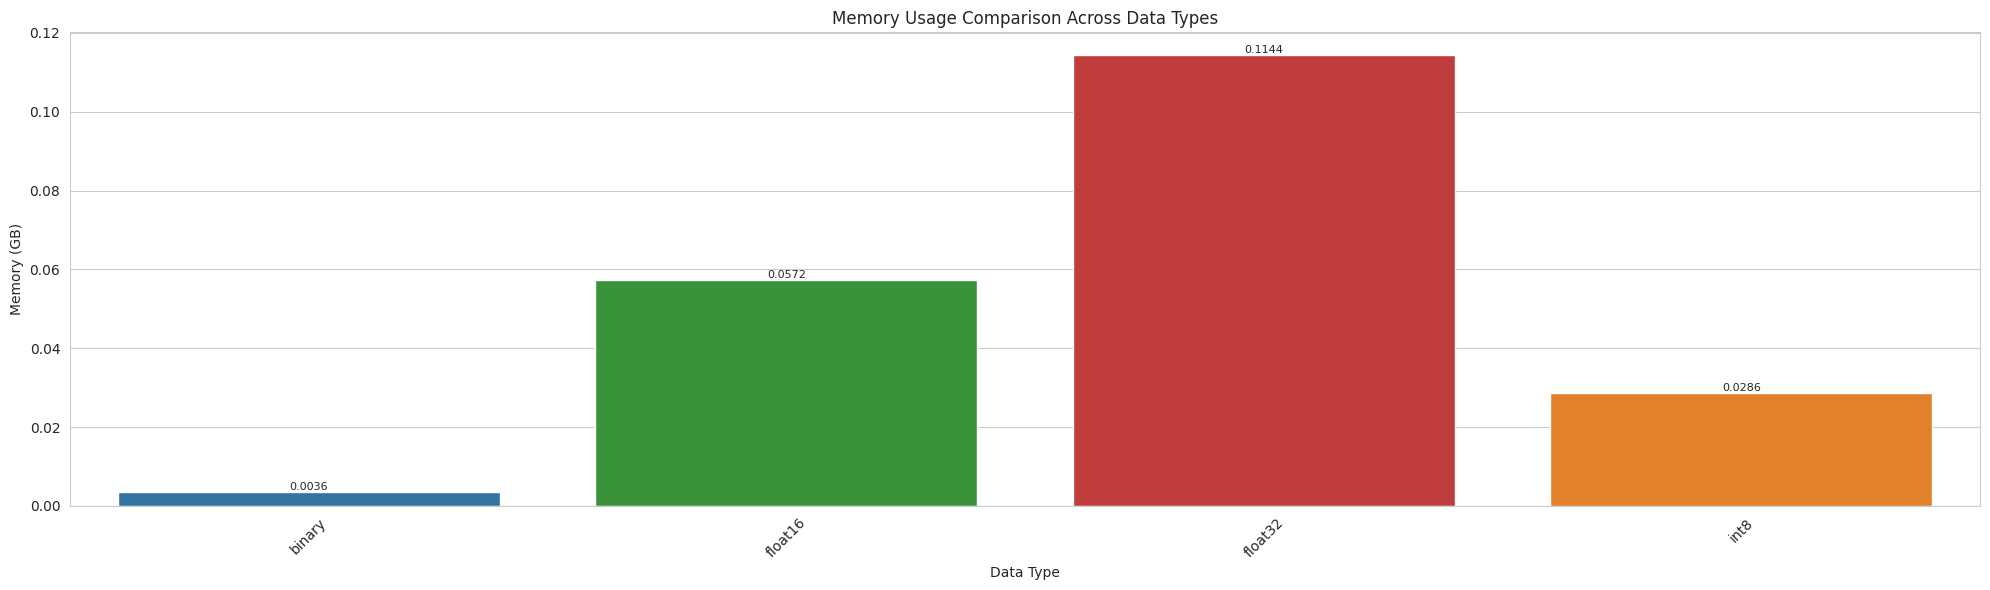

In [13]:
# Get all result files from the Qdrant experiment directory
results_dir = Path('../results/qdrant/BAAI/bge-small-en-v1.5')
result_files = list(results_dir.glob('results_*.json'))

# Group files by base data type
dtype_groups = {
    'float32': [],
    'float16': [],
    'int8': [],
    'binary': []
}

# Prepare data
dtypes = []
values = []
base_types = []

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Extract memory metric
            dtypes.append(dtype)
            values.append(data['theoretical_memory_gb'])
            base_types.append(base_type)

df = pd.DataFrame({
    'dtype': dtypes,
    'value': values,
    'base_type': base_types
})

# Create wide plot
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

# Create bar plot with colors by base type
ax = sns.barplot(data=df, x='dtype', y='value', hue='base_type',
            order=sorted(df['dtype'].unique()))

plt.title('Memory Usage Comparison Across Data Types')
plt.xlabel('Data Type')
plt.ylabel('Memory (GB)')
plt.xticks(rotation=45)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=8)

plt.tight_layout()
plt.show()


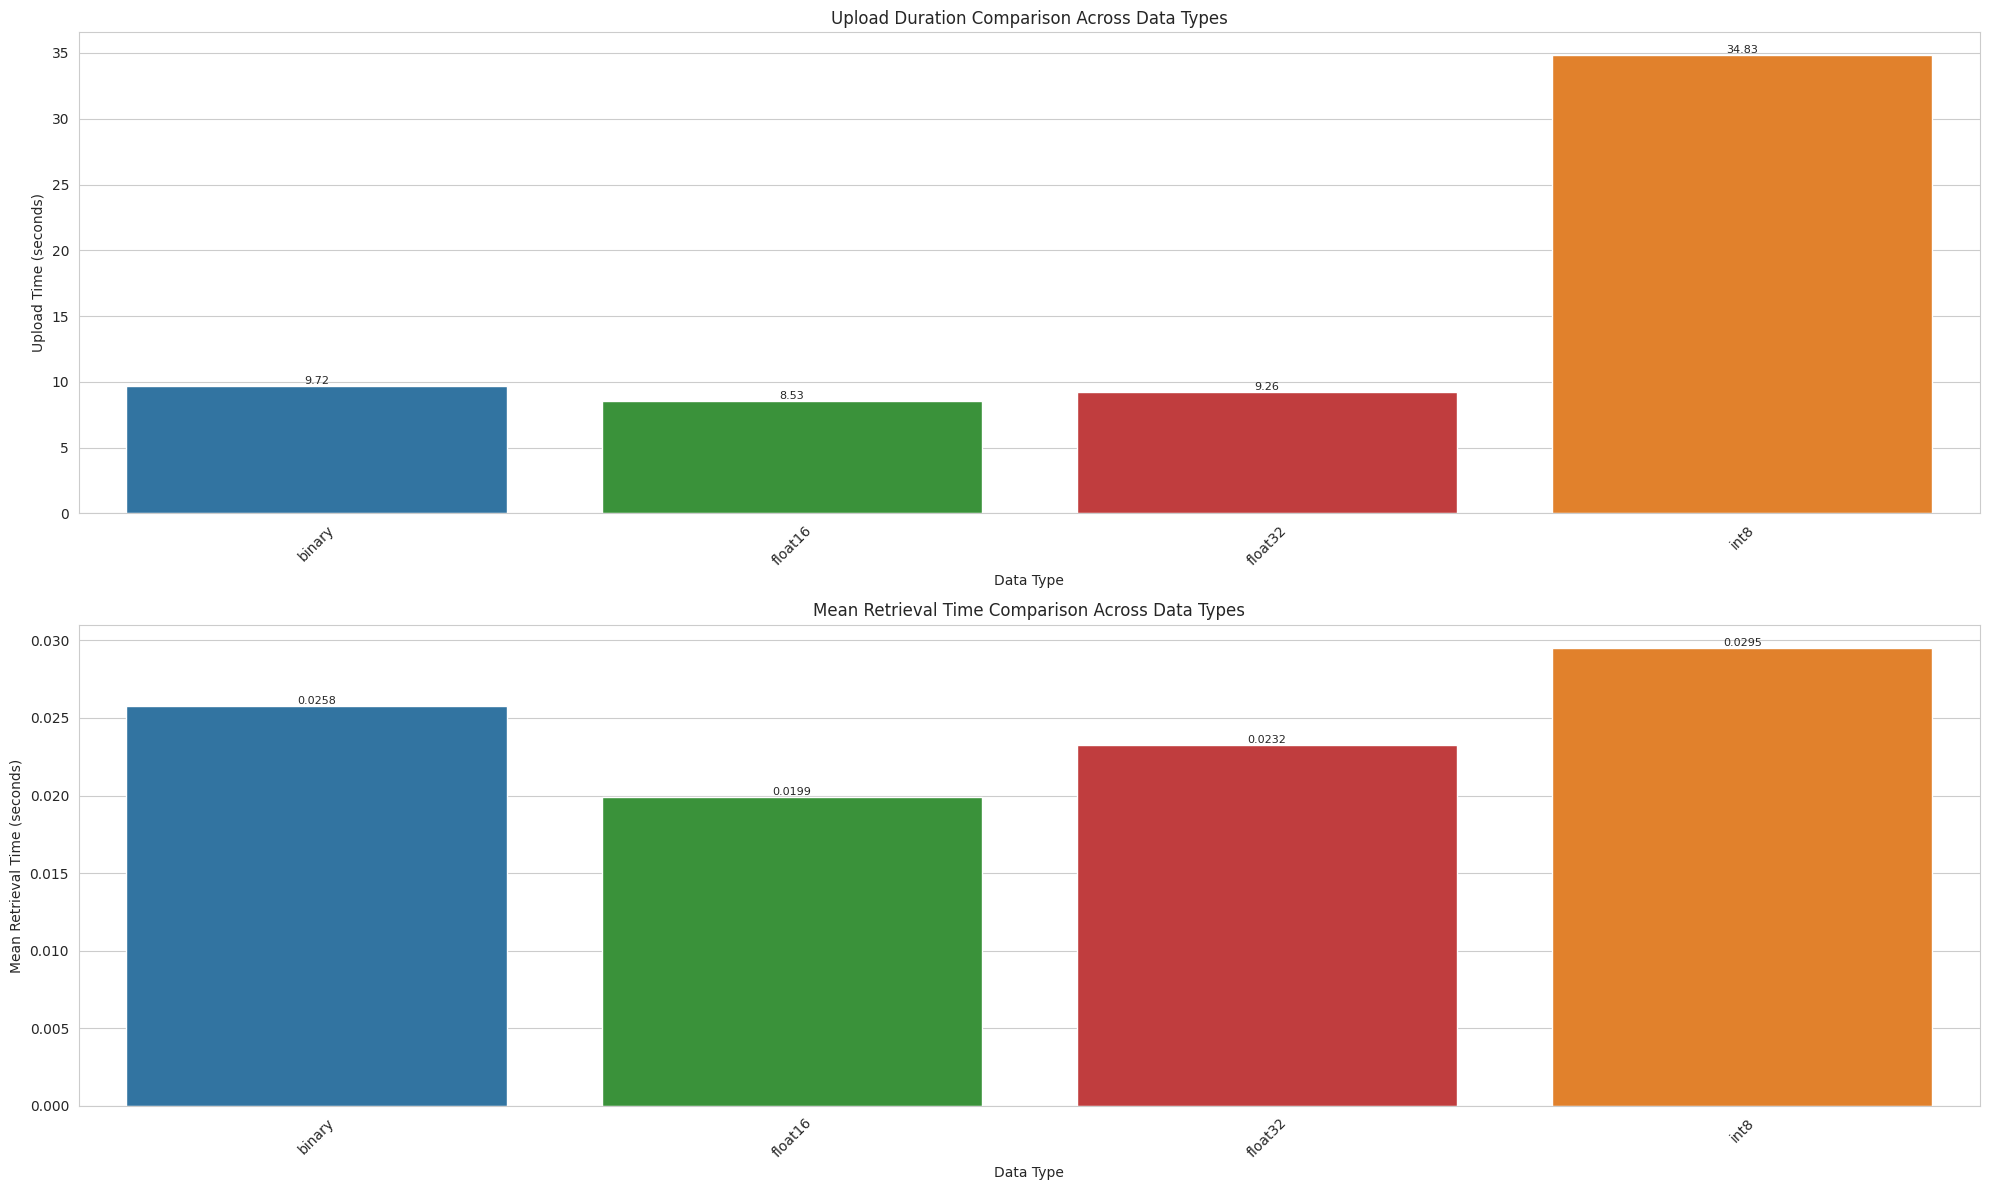

In [14]:
# Prepare data for upload and retrieval times
dtypes = []
upload_times = []
retrieval_times = []
base_types = []

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Extract timing metrics
            dtypes.append(dtype)
            upload_times.append(data['upload_duration_seconds'])
            retrieval_times.append(data['mean_retrieval_time'])
            base_types.append(base_type)

df_times = pd.DataFrame({
    'dtype': dtypes,
    'upload_time': upload_times,
    'retrieval_time': retrieval_times,
    'base_type': base_types
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.set_style("whitegrid")

# Upload time plot
sns.barplot(data=df_times, x='dtype', y='upload_time', hue='base_type',
            order=sorted(df_times['dtype'].unique()), ax=ax1)
ax1.set_title('Upload Duration Comparison Across Data Types')
ax1.set_xlabel('Data Type')
ax1.set_ylabel('Upload Time (seconds)')
ax1.tick_params(axis='x', rotation=45)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', fontsize=8)

# Retrieval time plot  
sns.barplot(data=df_times, x='dtype', y='retrieval_time', hue='base_type',
            order=sorted(df_times['dtype'].unique()), ax=ax2)
ax2.set_title('Mean Retrieval Time Comparison Across Data Types')
ax2.set_xlabel('Data Type')
ax2.set_ylabel('Mean Retrieval Time (seconds)')
ax2.tick_params(axis='x', rotation=45)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.4f', fontsize=8)

plt.tight_layout()
plt.show()


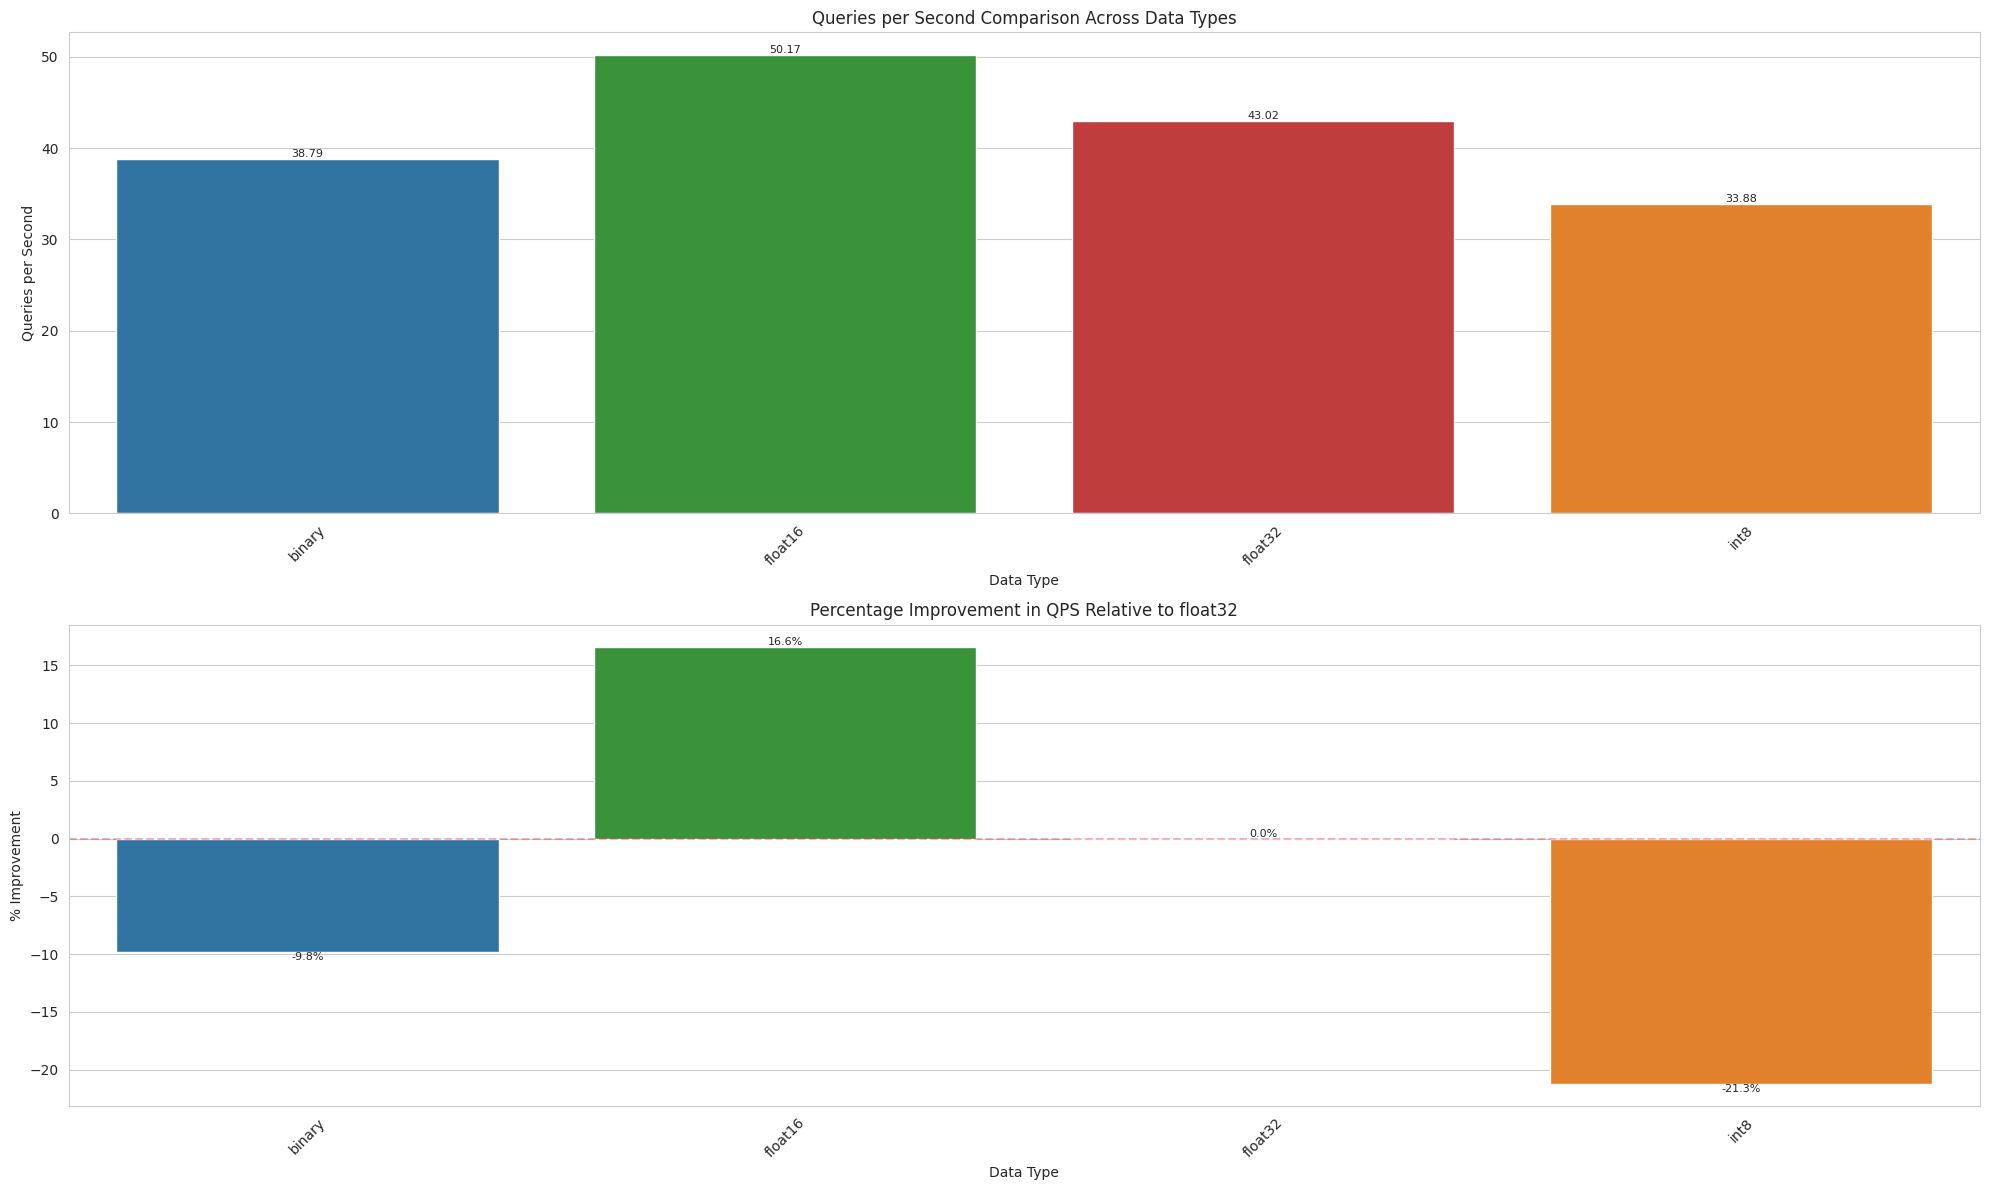

In [15]:
# Prepare data for queries per second
dtypes = []
qps = []
base_types = []

# First get baseline QPS from float32
with open(result_files[0].parent / 'results_float32.json', 'r') as f:
    baseline_qps = json.load(f)['queries_per_second']

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Extract QPS metric
            dtypes.append(dtype)
            qps.append(data['queries_per_second'])
            base_types.append(base_type)

df_qps = pd.DataFrame({
    'dtype': dtypes,
    'queries_per_second': qps,
    'base_type': base_types
})

# Add percentage improvement column
df_qps['pct_improvement'] = ((df_qps['queries_per_second'] - baseline_qps) / baseline_qps) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.set_style("whitegrid")

# Absolute QPS plot
sns.barplot(data=df_qps, x='dtype', y='queries_per_second', hue='base_type',
            order=sorted(df_qps['dtype'].unique()), ax=ax1)
ax1.set_title('Queries per Second Comparison Across Data Types')
ax1.set_xlabel('Data Type')
ax1.set_ylabel('Queries per Second')
ax1.tick_params(axis='x', rotation=45)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', fontsize=8)

# Percentage improvement plot
sns.barplot(data=df_qps, x='dtype', y='pct_improvement', hue='base_type',
            order=sorted(df_qps['dtype'].unique()), ax=ax2)
ax2.set_title('Percentage Improvement in QPS Relative to float32')
ax2.set_xlabel('Data Type') 
ax2.set_ylabel('% Improvement')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.show()


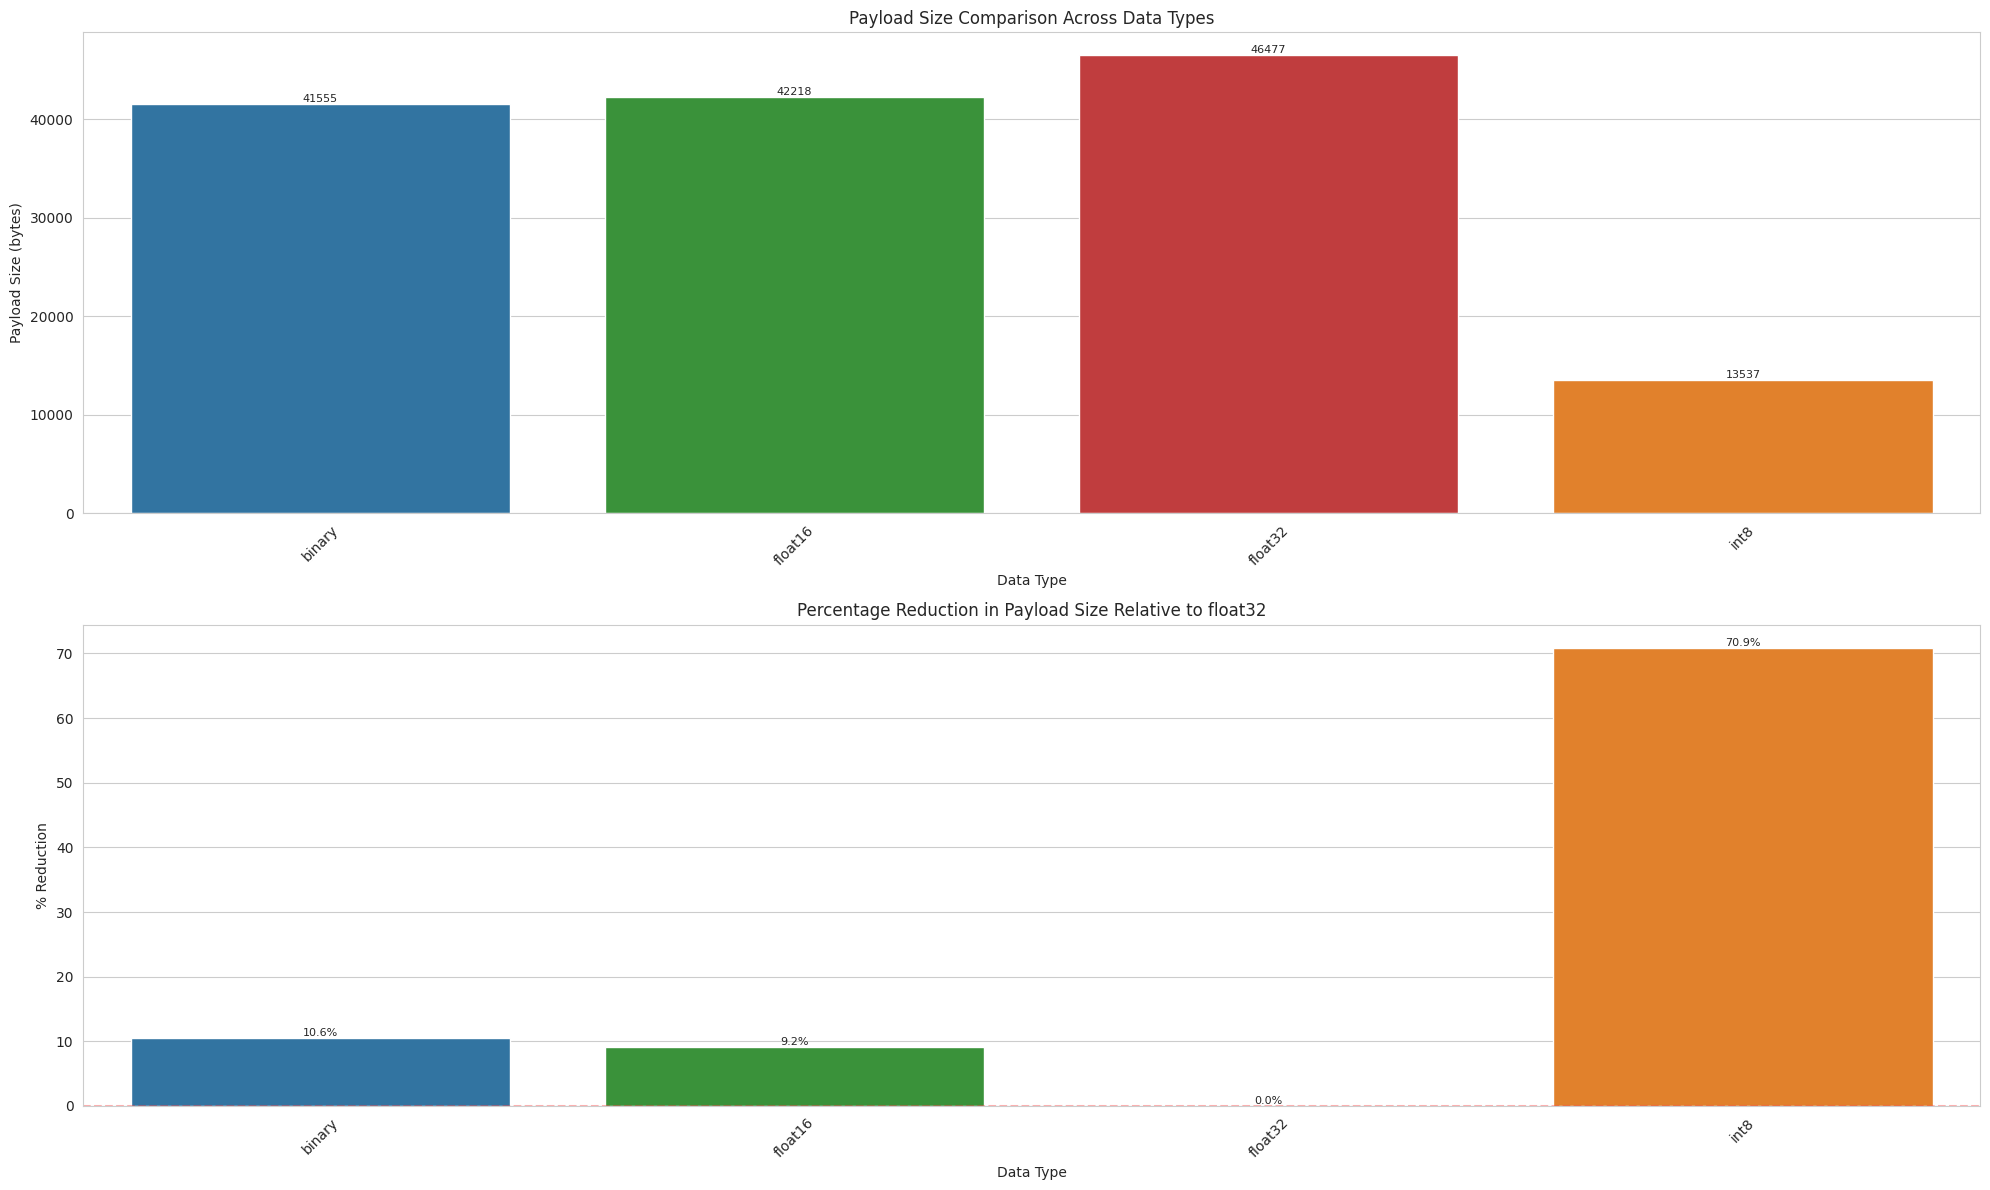

In [16]:
# Prepare data for payload size
dtypes = []
payload_sizes = []
base_types = []

# First get baseline payload size from float32
with open(result_files[0].parent / 'results_float32.json', 'r') as f:
    baseline_size = json.load(f)['avg_payload_size_bytes']

for result_file in result_files:
    dtype = result_file.stem.replace('results_', '')
    # Match files to their base type
    for base_type in dtype_groups.keys():
        if base_type in dtype:
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Extract payload size metric
            dtypes.append(dtype)
            payload_sizes.append(data['avg_payload_size_bytes'])
            base_types.append(base_type)

df_size = pd.DataFrame({
    'dtype': dtypes,
    'avg_payload_size_bytes': payload_sizes,
    'base_type': base_types
})

# Add percentage improvement column (reduction in size)
df_size['pct_improvement'] = ((baseline_size - df_size['avg_payload_size_bytes']) / baseline_size) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.set_style("whitegrid")

# Absolute payload size plot
sns.barplot(data=df_size, x='dtype', y='avg_payload_size_bytes', hue='base_type',
            order=sorted(df_size['dtype'].unique()), ax=ax1)
ax1.set_title('Payload Size Comparison Across Data Types')
ax1.set_xlabel('Data Type')
ax1.set_ylabel('Payload Size (bytes)')
ax1.tick_params(axis='x', rotation=45)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', fontsize=8)

# Percentage improvement plot
sns.barplot(data=df_size, x='dtype', y='pct_improvement', hue='base_type',
            order=sorted(df_size['dtype'].unique()), ax=ax2)
ax2.set_title('Percentage Reduction in Payload Size Relative to float32')
ax2.set_xlabel('Data Type')
ax2.set_ylabel('% Reduction')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.show()
